In [ ]:
## 新闻文本数据分类  

### 介绍

在上一实验中我们熟悉了简单的深度神经网络，在本实验中，我们基于其进行实战，即对一些英语新闻文本，实现模型自动预测其主题标签从而进行分门别类，主要包括以下知识点：

In [ ]:
#### 知识点

In [ ]:
- 新闻数据预处理
- 多层神经网络模型搭建
- 新闻分类器的训练及测试

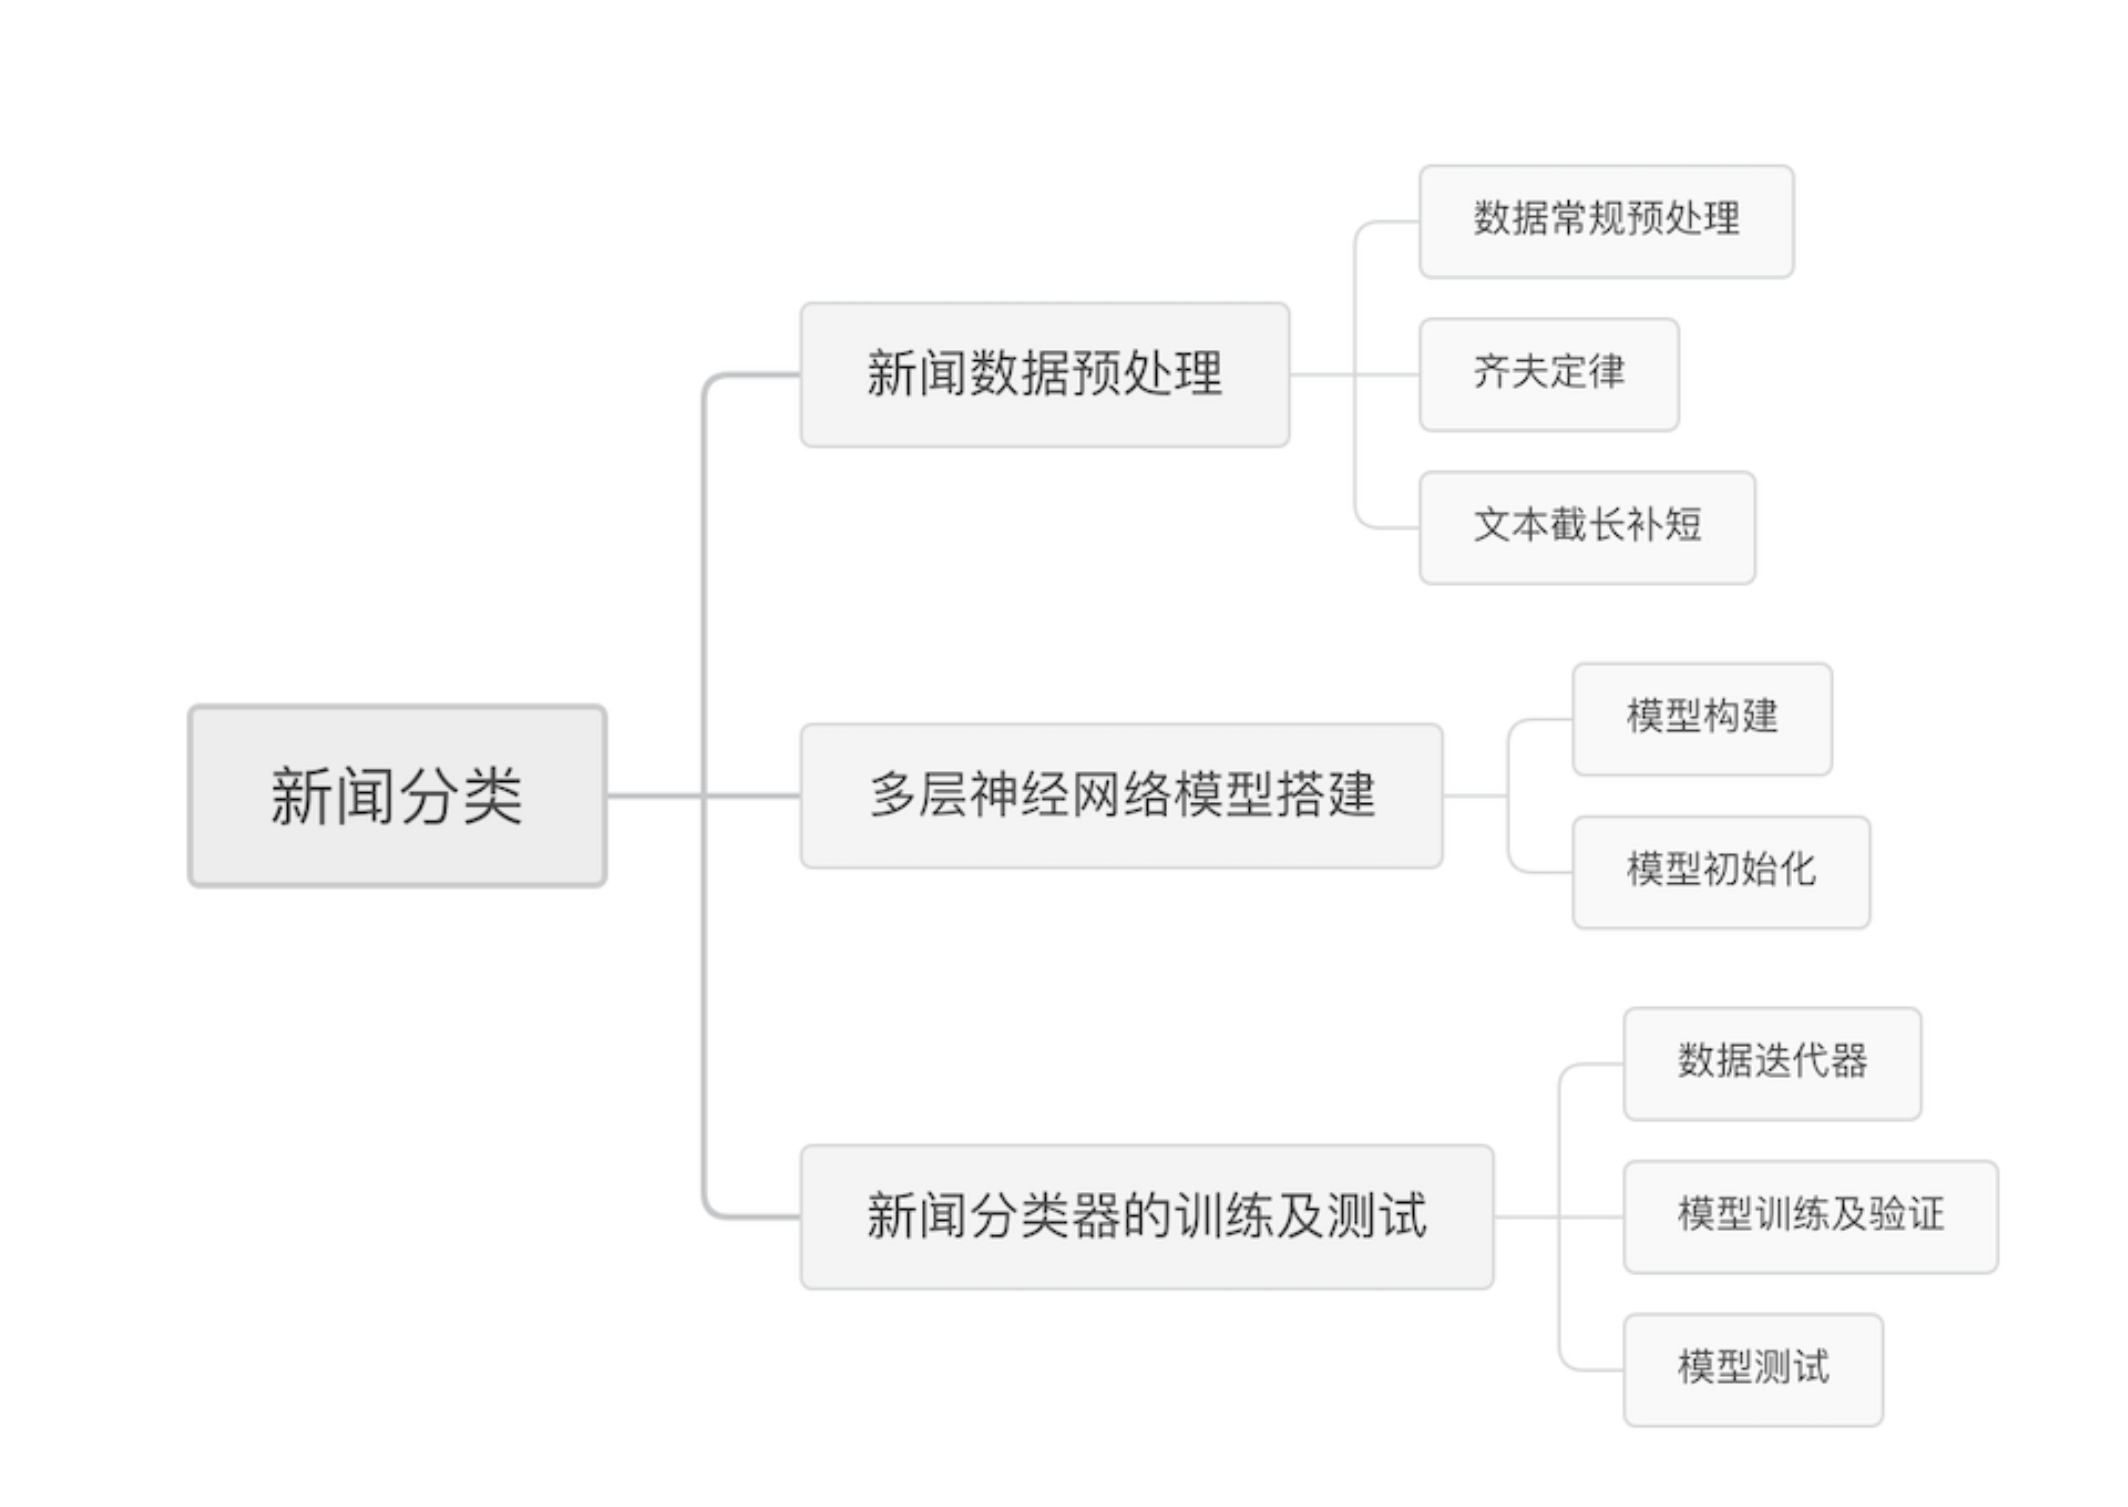

### 新闻数据预处理

永远记住数据才是<font color=#0099ff>**天花板**</font>，在文本处理相关的项目中，对数据的的预处理是非常重要的一个步骤，而在实际工作中，这部分工作反而比模型构建需要花费更多的时间与精力，一个优秀的自然语言处理工程师往往能够精准地发现业务数据的<font color=#0099ff>**特别之处**</font>以及进行适应相关任务性质的<font color=#0099ff>**特殊预处理**</font>。首先让我们来熟悉本实验中的新闻数据：

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
import pandas as pd
# 从环境中下载实验数据
!wget -nc 'https://labfile.oss.aliyuncs.com/courses/3382/train.csv'
!wget -nc 'https://labfile.oss.aliyuncs.com/courses/3382/test.csv'
# 读取原始的训练数据及测试数据
train_data_ori = pd.read_csv("train.csv",header=None)
test_data_ori = pd.read_csv("test.csv",header=None)
train_data_ori.head(10)  # 查看前 10 行

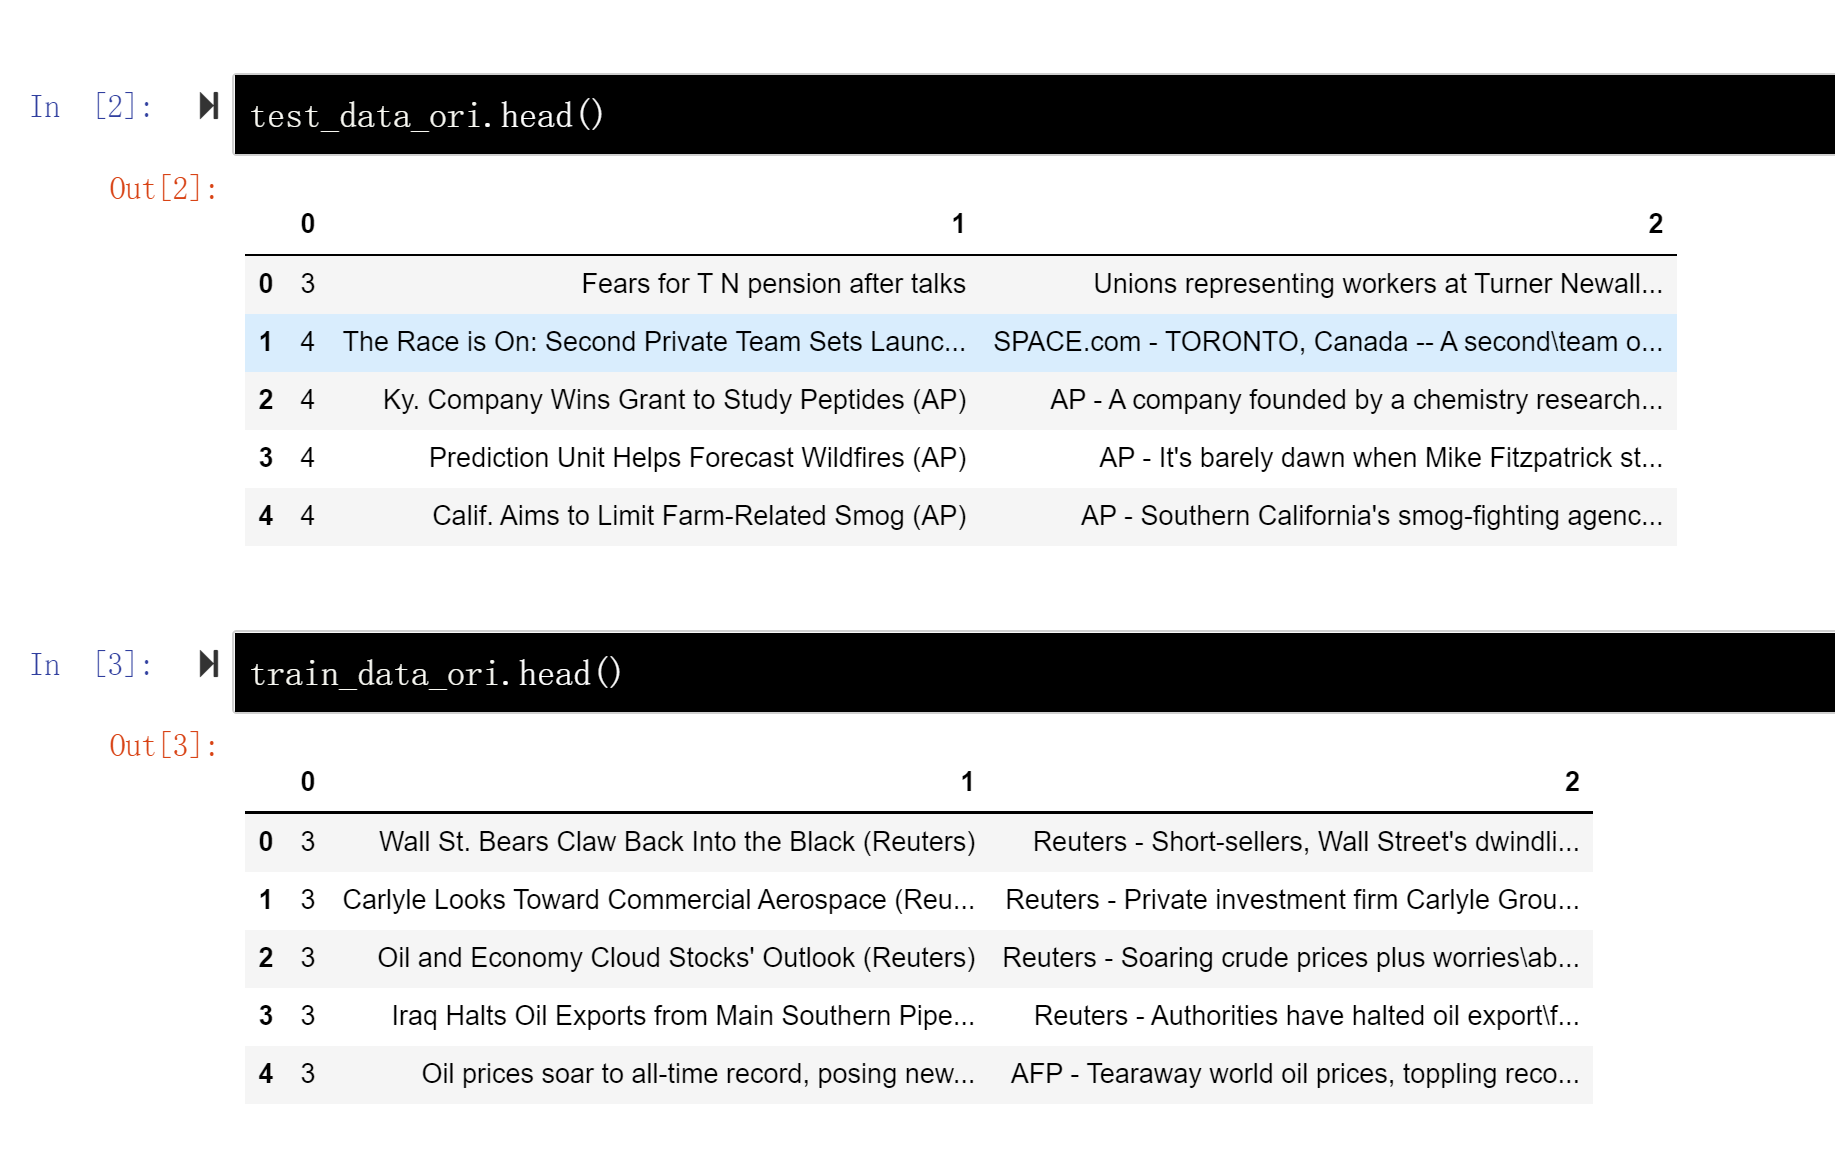

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习：</i>

由以上内容可知，CSV 数据的首列为主题标签，第二列为新闻题目，第三列则为具体的新闻文本。

接下来对英语新闻文本进行基本的常规预处理，主要包括以下几个方面：

In [ ]:
- 去除停用词以及非字母符号
- 所有字母转小写并且分词
- 词形还原
- 去停用词

In [ ]:
以上处理过程是一般字母语言（如英文、法文、德文等）的文本中常用的手段，而精准特殊的预处理往往需要在熟悉业务数据以及任务目标的基础上，在项目优化迭代的过程中适时尝试。

In [ ]:
首先获取停用词：

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/eng-stopwords.txt"
with open("eng-stopwords.txt","r") as f:
    STOPWORDS = set([line.strip() for line in f.readlines()]) # 英语停用词
print(STOPWORDS)

我们使用 NLTK 对英文文本进行处理时，首先需要下载 NLTK 拓展包，你可以使用 `nltk.download()` 来选择性下载所需拓展包或者直接使用 `python -m nltk.downloader all` 下载全部数据拓展包。

In [ ]:
由于访问境外网络较慢，所以这里从蓝桥云课服务器下载相应数据扩展包。

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/nltk_data.zip"
!unzip -o "nltk_data.zip" -d /root/

In [ ]:
本地使用时，你可以执行：

In [ ]:

import nltk

nltk.download('punkt')  # 下载英文分词所需拓展包
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


接下来设计文本相关预处理函数：

In [ ]:
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer  # 导入 nltk.stem 用来词形还原

WML = WordNetLemmatizer()  # 词形还原器

def get_wordnet_pos(tag):
    # 获取 wordnet 形式的单词词性用于词形还原,只考虑常见的几种词性，并且默认为 NOUN
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_data(sentence):
    sentence = re.sub("[^a-z ]", "", sentence.lower())  # 去除停用词以及非字母符号
    tokens = word_tokenize(sentence)  # 转小写并分词
    tagged_sent = pos_tag(tokens)     # 获取单词词性，用于词形还原
    lemmas_sent = []
    for token, tag in zip(tokens, tagged_sent):
        if token not in STOPWORDS:  # 去除停用词
            wordnet_pos = get_wordnet_pos(tag[1])  # tag[1] 指单词词性
            lemmas_sent.append(WML.lemmatize(
                tag[0], pos=wordnet_pos))  # tag[0] 指单词本身
    return lemmas_sent

分别基于以上流程，预处理训练数据及测试数据，并保存为文件 CSV 格式：

In [ ]:
from tqdm import tqdm

# 预处理训练数据并保存为文件 csv 格式
traindata = [preprocess_data(text) for text in tqdm(train_data_ori[2])]
pd.DataFrame({"data": traindata, "label": train_data_ori[0]}).to_csv(
    "traindata_preprocessed.csv")

# 预处理测试数据并保存为文件 csv 格式
testdata = [preprocess_data(text) for text in tqdm(test_data_ori[2])]
pd.DataFrame({"data": testdata, "label": test_data_ori[0]}).to_csv(
    "testdata_preprocessed.csv")


在模型中，文本均以词汇 id 的组合形式作为其表征，因此需要提前基于训练数据构建单词与 id 对应的<font color=#0099ff>**词汇表**</font>。词典中预先存放 < PAD >  和 < UNK >，分别对应<font color=#0099ff>**空位符**</font>以及<font color=#0099ff>**未登录词**</font>。

In [ ]:
# 构建词汇与 id 对应的词典
def build_vocab(train_file_path):
    # 词典中预先存放 "<PAD>" 和 "<UNK>"
    word2id = {"<PAD>": 0, "<UNK>": 1}
    for text in pd.read_csv(train_file_path)["data"]:  # 遍历数据
        for word in eval(text):
            if word not in word2id:  # 将首次见到的词汇加入词典
                word2id[word] = len(word2id)
    return word2id

In [ ]:
查看词典大小：

In [ ]:
word2id = build_vocab("traindata_preprocessed.csv")
vocab_size = len(word2id)
vocab_size

对于文本数据而言，需要在模型中首先内置<font color=#0099ff>**词向量层**</font>，实际上是大小为<font color=#0099ff>**“词典大小*词向量大小”**</font>的全连接层，将以<font color=#0099ff>**独热向量**</font>表示的高维词汇表征映射到<font color=#0099ff>**低维的稠密空间**</font>。如果词典过大，会导致词向量层参数过多，并且“词典大小”与“词向量大小”差别过大，也会影响模型性能。因此一般会将一些不太常用的低频词去除，以减小词典大小。

In [ ]:
from collections import Counter

def build_vocab_by_delete_lowfreqword(train_file_path, min_freq=2):
    # 词典过大会对模型造成负担，可去除低频词重新构建
    # 重新构建词汇与 id 对应的词典
    allwords = []
    for text in pd.read_csv(train_file_path)["data"]:  # 遍历数据
        allwords.extend(eval(text))
    vocab = Counter(allwords)

    # 词典中预先存放 "<PAD>" 和 "<UNK>"
    word2id = {"<PAD>": 0, "<UNK>": 1}
    for word in vocab:  # 遍历词典
        if vocab[word] > min_freq:  # 将首次见到的词汇加入词典
            word2id[word] = len(word2id)
    return word2id

查看缩减后的词典大小：

In [ ]:
WORD2ID = build_vocab_by_delete_lowfreqword("traindata_preprocessed.csv")
VOCAB_SIZE = len(WORD2ID)
VOCAB_SIZE

为什么可以直接去除低频词，对语料不会产生什么影响吗？这里可以用<font color=#0099ff>**齐夫定律**</font>（哈佛大学语言学家乔治·金斯利·齐夫于 1949 年发表的实验定律）来解释。在自然语言的语料库里,一个单词出现的频率与它在频率表里的排名成<font color=#0099ff>**反比**</font>。所以，频率最高的单词出现的频率大约是出现频率第二位的单词的 2 倍，而出现频率第二位的单词则是出现频率第四位的单词的 2 倍，以此类推。

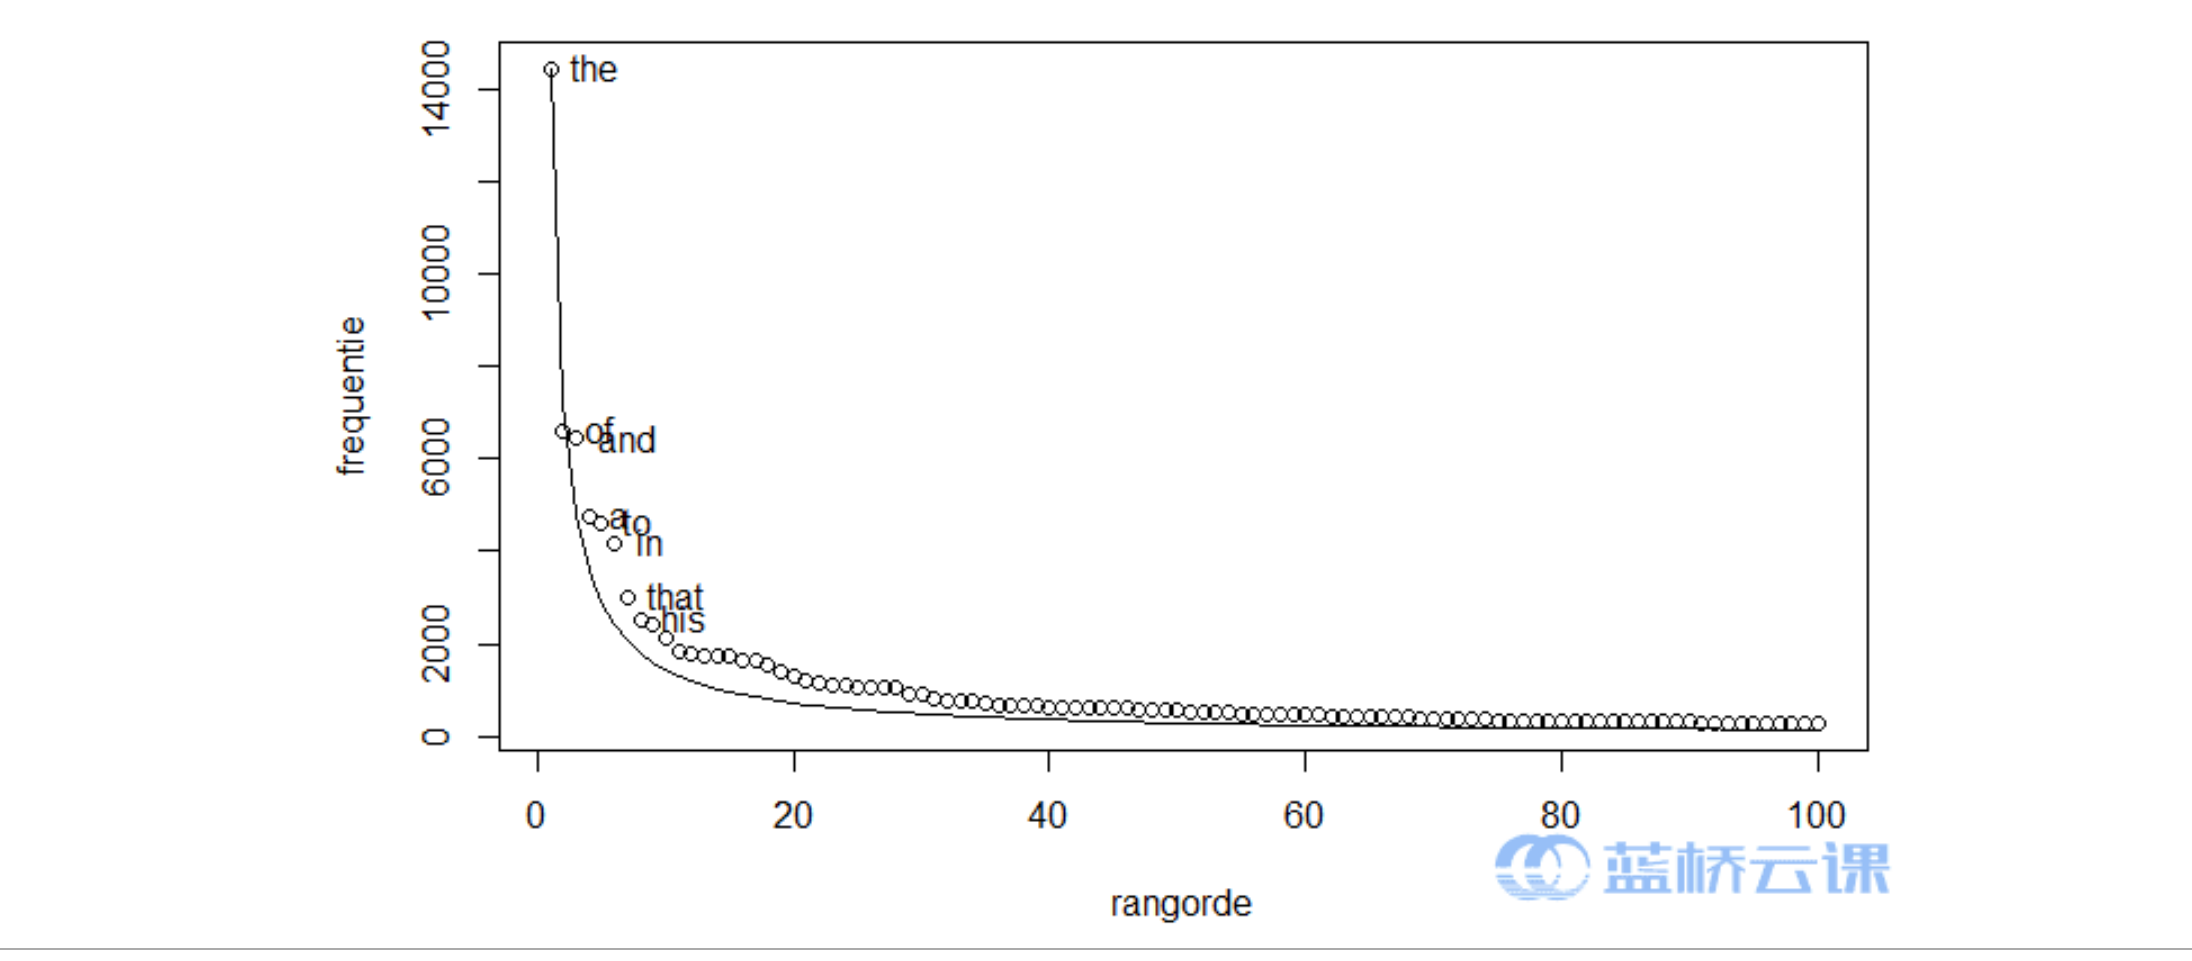

通过对大量语料的统计，人们发现以下两条规律：

- 少部分频率高的词汇占据了语料的大部分内容。
- 大部分的单词出现频率低。

其实可以联系实际生活想想，掌握上千个中文单词便可以应对基本的日常用语，而中文总词汇总量在 50-70 万左右，而其中的大部分词汇并不常用。

因此，去除低频词合理，背后的直觉在于：

- 出现频率特别低的词汇对语料整体的语义<font color=#0099ff>**影响不大**</font>。
- 极大地<font color=#0099ff>**减少计算复杂度**</font>（减小词典单词量）。

当去除低频词阈值 `min_freq = 2`时，词典大小减少了一半多，可以调节此阈值 `min_freq` 进行对比实验。

接下来，由于在训练过程中，数据<font color=#0099ff>**一批批地**</font>进行输入，由于数据中网络中以<font color=#0099ff>**矩阵形式**</font>进行运算，一批数据中的文本长度需要<font color=#0099ff>**保持一致**</font>，因此要对文本进行<font color=#0099ff>**截长补短**</font>。

In [ ]:
# 将文本转化为 id，并且截长补短
def load_dataset(file_path, pad_size):
    datasets = []
    content = pd.read_csv(file_path)
    for data, label in zip(content["data"], content["label"]):
        data_idx = []
        data = eval(data)
        seq_len = len(data)
        if pad_size <= seq_len:  # 将文本进行截长补短
            data = data[:pad_size]
        else:
            data.extend(["<PAD>"]*(pad_size-seq_len))
        for word in data:  # 将文本转化为 id
            data_idx.append(WORD2ID.get(word, WORD2ID.get("<UNK>")))
        datasets.append((data_idx, label))
    return datasets

In [ ]:
如何选取合适的固定长度呢？可对全体新闻文本进行<font color=#0099ff>**长度分布**</font>统计，再决定固定长度。

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# 对文本长度进行统计，选取合适的 pad_size
lens = [len(eval(i)) for i in pd.read_csv(
    "traindata_preprocessed.csv")["data"]]
plt.hist(lens)

观察文本长度总体分布，综合而言，取 30 比较合适，因为 30 以上长度的文本比较少。

In [ ]:
traindataset = load_dataset("traindata_preprocessed.csv", pad_size=30)
testdataset = load_dataset("testdata_preprocessed.csv", pad_size=30)

len(traindataset), len(testdataset)

### 多层神经网络模型搭建

基于 PyTorch 进行模型搭建，模型主要由全连接层和非线性层 ReLU 构成：

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    # 搭建模型
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # 词嵌入层
        self.hidden_layer = nn.Linear(embed_dim, hidden_dim)  # 隐藏层
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(hidden_dim, num_class)  # 输出层

    def forward(self, x):
        # x = [batch_size, seq_len]
        embedded = self.embedding(x)
        # embedded = [batch_size, seq_len, embed_dim]
        embedded = torch.mean(embedded, dim=1)  # 对句子中所有词嵌入取平均
        # embedded = [batch_size, embed_dim]
        hidden = self.hidden_layer(embedded)
        hidden = self.relu(hidden)  # 非线性运算
        # hidden = [batch_size, hidden_dim]
        return self.fc(hidden)

设定词向量维度、隐层维度以及输出维度（类别数量），并且初始化模型：

In [ ]:
import torch

EMBED_DIM = 300  # 词向量维度
HIDDEN_DIM = 82  # 隐层维度
NUM_CLASS = 4  # 输出维度

DEVICE = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")  # 如果有 GPU, 将数据与模型转换到 cuda
classifier = TextClassifier(VOCAB_SIZE, EMBED_DIM,
                            HIDDEN_DIM, NUM_CLASS).to(DEVICE)  # 初始化模型
classifier

### 新闻分类器的训练及测试

以上部分完成了基本的数据预处理以及模型初始化，接下来进行模型训练。由于训练过程中会进行数据批次化训练，这里首先需要构建一个<font color=#0099ff>**数据迭代器**</font>，能够批次化地输出数据。在数据迭代器的构建过程中，需要注意两点：

- 数据总量是否能被批次大小 `batch_size` 整除，需要分情况讨论。
- 数据需要转化为 tensor 的形式。

In [ ]:
import math

class DatasetIterator:
    # 数据迭代器
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size  # 一批数据量的大小
        self.dataset = dataset
        self.n_batches = math.floor(len(dataset)/batch_size)  # 向下取整的批次大小
        self.num = len(dataset)  # 数据量大小
        self.residue = True  # 默认不可以取整
        if len(dataset) % self.batch_size == 0:  # 所有数据量是否能被批数据量整除
            self.residue = False
        self.index = 0

    def _to_tensor(self, datas):  # 将数据转换为 tensor，并且 copy 一份到 device 所指定的环境上
        x = torch.LongTensor([_[0] for _ in datas]).to(DEVICE)
        # -1 是因为标签需要从 0 开始编号，而数据中的标签从 1 开始编号
        y = torch.LongTensor([_[1]-1 for _ in datas]).to(DEVICE)
        return x, y

    def __next__(self):  # 返回迭代器的下一个元素
        if self.residue and self.index == self.n_batches:  # 在不能取整的情况下，对于最后一批数据，需要额外分为一种情况
            batch_data = self.dataset[self.index *
                                      self.batch_size:len(self.dataset)]
            self.index += 1
            batch_data = self._to_tensor(batch_data)
            return batch_data  # 返回一个 batch 的数据
        elif self.index >= self.n_batches:  # 当 index 超出范围时，停止迭代
            self.index = 0
            raise StopIteration
        else:  # 其它情况
            batch_data = self.dataset[self.index *
                                      self.batch_size:(self.index+1)*self.batch_size]
            self.index += 1
            batch_data = self._to_tensor(batch_data)
            return batch_data

    def __iter__(self):
        return self

    def __len__(self):  # 迭代器长度
        if self.residue:  # 如果不能取整，迭代器中的元素为向下取整的值 +1
            return self.n_batches + 1
        else:
            return self.n_batches

设置随机种子，保证结果可复现：

In [ ]:
import random
# 保证每次结果一样
SEED = 123
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

将原来的训练数据划分为训练集和验证集，并初始化数据迭代器：

In [ ]:
from torch.utils.data.dataset import random_split

BATCH_SIZE = 60
IF_SHUFFLE = True  # 是否打乱数据

if IF_SHUFFLE:
    random.shuffle(traindataset)

# 将数据划分为训练集和验证集
train_len = int(len(traindataset) * 0.8)
sub_train, sub_valid = random_split(
    traindataset, [train_len, len(traindataset) - train_len])
train_iter = DatasetIterator(list(sub_train), BATCH_SIZE)  # 训练数据
valid_iter = DatasetIterator(list(sub_valid), BATCH_SIZE)  # 验证数据

In [ ]:
接下来构建两个函数，分别用于训练模型以及验证（或者测试）模型。

训练函数主要包含以下步骤：

- 模型设置为训练模式；
- 设置优化器；
- 遍历数据进行训练；
    - 模型预测结果；
    - 损失计算；
    - 损失回传；
    - 参数更新；
- 计算总体损失及准确率。

In [ ]:
def train(model, data_iter):
    # 训练模型
    model.train()  # 训练模式
    train_loss = 0
    train_acc = 0
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # 优化器
    for i, (texts, labels) in enumerate(data_iter):  # 遍历数据
        output = model(texts)  # 模型预测结果
        model.zero_grad()  # 清空梯度
        loss = F.cross_entropy(output, labels)  # 计算损失
        train_loss += loss.item()  # 叠加损失
        loss.backward()  # 损失回传
        optimizer.step()
        train_acc += (output.argmax(1) == labels).sum().item()  # 计算准确率

    return train_loss / data_iter.num, train_acc / data_iter.num

验证（或者测试）函数主要包含以下步骤：

- 模型设置为测试模式；
- 遍历数据进行测试；
    - 模型预测结果；
    - 损失计算；
- 计算总体损失及准确率。

In [ ]:
def test(model, data_iter):
    # 测试
    model.eval()  # 测试模式
    test_loss = 0
    acc = 0

    for texts, labels in data_iter:
        with torch.no_grad():
            output = model(texts)
            loss = F.cross_entropy(output, labels)  # 计算损失
            test_loss += loss.item()
            acc += (output.argmax(1) == labels).sum().item()

    return test_loss / data_iter.num, acc / data_iter.num

接下来进行模型训练，在训练过程中需要计时、训练结果可视化以及保存最好的模型。

In [ ]:
import time

N_EPOCHS = 1
best_valid_loss = float('inf')
# 开始训练
for epoch in range(N_EPOCHS):
    start_time = time.time()  # 计时

    train_loss, train_acc = train(classifier, train_iter)
    valid_loss, valid_acc = test(classifier, valid_iter)

    if valid_loss < best_valid_loss:  # 保存最好的模型
        best_valid_loss = valid_loss
        torch.save(classifier.state_dict(), 'classifier_cpu.pkl')

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    # 训练过程可视化
    print('Epoch: %d' % (epoch + 1),
          " | %d minutes, %d seconds" % (mins, secs))
    print(
        f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(
        f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

由于在线环境运行较慢，上面只训练了 1 个 EPOCH 作为演示。接下来，你可以下载我在本地训练了 15 个 EPOCH 的模型用于推理：

In [ ]:
# 下载本地预训练模型
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/classifier.pkl"
classifier.load_state_dict(torch.load("classifier.pkl", map_location=torch.device('cpu')))
test_iter = DatasetIterator(testdataset, BATCH_SIZE)

In [ ]:
查看测试效果：

In [ ]:
print('测试结果：')
test_loss, test_acc = test(classifier, test_iter)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

In [ ]:
### 实验总结

本实验基于简单的神经网络模型实现了对新闻文本数据的多分类，在最后的测试集上达到了 70% 的准确率。事实上，我们还有更多可更改的设置来尝试提高最终的测试结果，比如更多的数据预处理操作、修改模型结构、改变训练相关参数等。

本实验的主要知识点如下：

- 新闻数据预处理
- 多层神经网络模型搭建
- 新闻分类器的训练及测试

在本实验中，对于输入的文本序列，转化为词向量后对序列长度的维度上进行平均。这种平均方式存在一大问题，没有考虑到<font color=#0099ff>**语序**</font>，也就是“我打你”和“你打我”成了一个意思。那么，什么模型能够考量到语序信息呢？下一实验中将学习的循环神经网络便能够针对这一问题，对“我打你”和“你打我”进行有效区分。